# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [2]:
#Import all the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from PIL import Image

from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import time

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

root_path = './'

images= root_path + '/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    
    text = pd.read_csv(root_path+ "/"+filename, sep=",")
    
    #text=open(root_path+ "/"+filename).read()
    
    
    return text

text_file = "captions.txt"
doc = load_doc(text_file)
print(doc[:300])
#pd.DataFrame(doc)



                         image  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
295  A boy in blue shorts slides down a slide into ...  
296  A boy in blue swimming trunks slides down a ye...  
297  A boy rides down a slide into a small backyard...  
298  A boy sliding do

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
#img_id = [i.split(',')[0] for i in doc.splitlines()[1:]]
#img_caption = [i.split(',')[1] for i in doc.splitlines()[1:]]

In [6]:
all_img_id= pd.DataFrame(doc)["image"] #store all the image id here
#all_img_id= img_id

all_img_vector= [images+"/"+i for i in pd.DataFrame(doc)["image"]] #store all the image path here
#all_img_vector= [images+"/"+i for i in img_id]

annotations= pd.DataFrame(doc)["caption"] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,.//Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,.//Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,.//Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,.//Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,.//Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,.//Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,.//Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,.//Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,.//Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


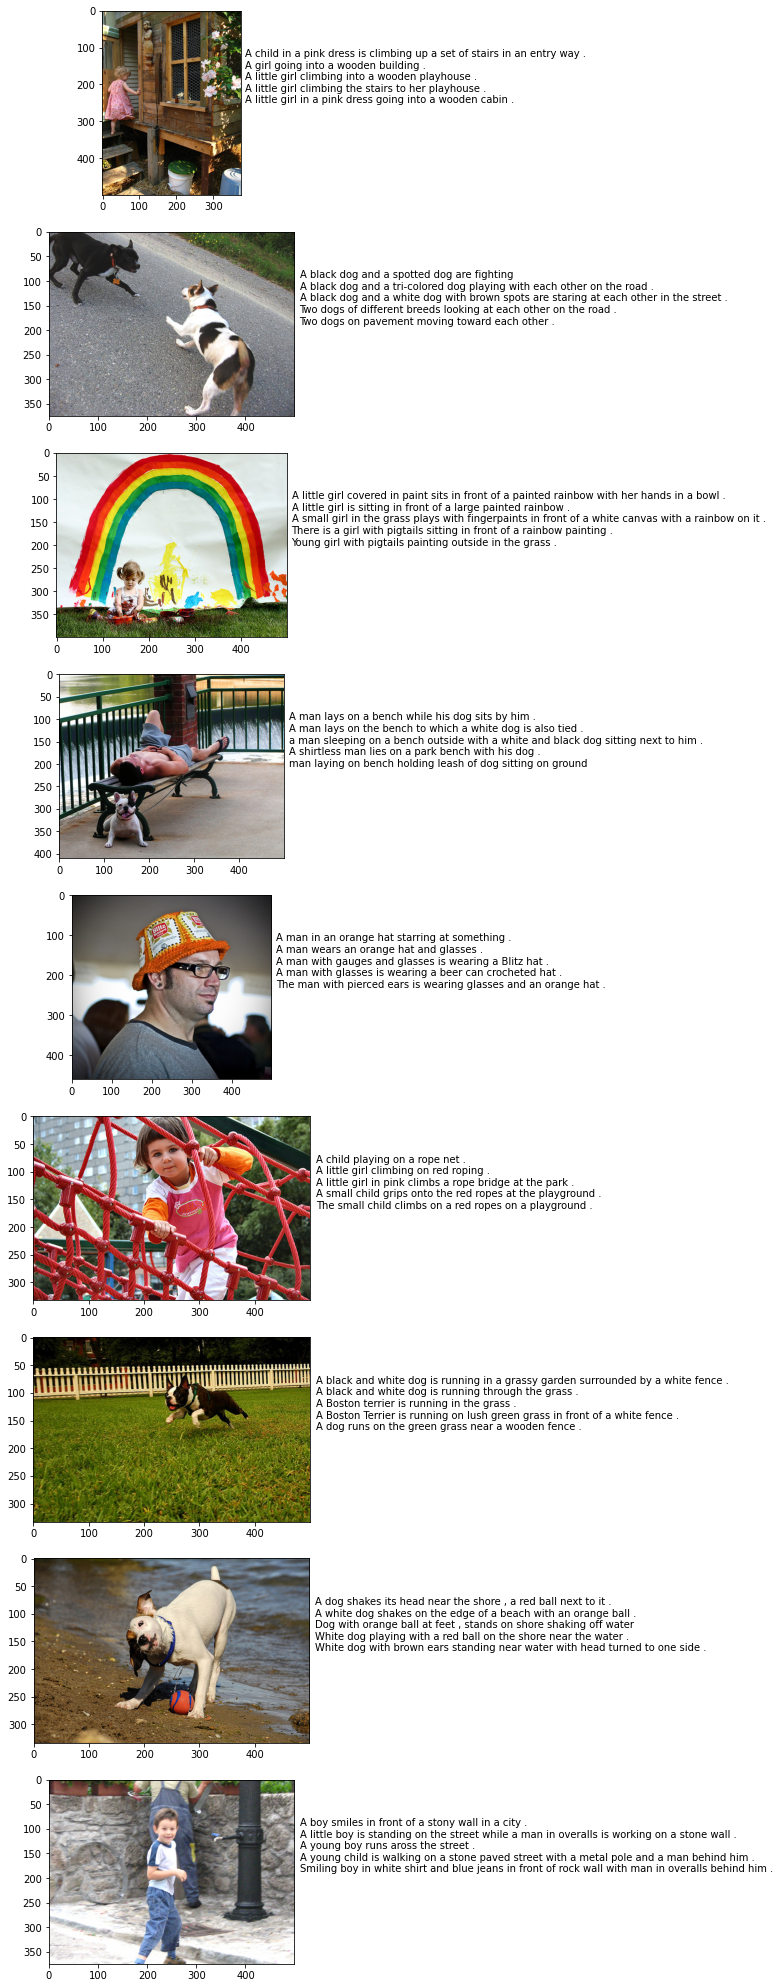

In [7]:
plt.figure(figsize=(40, 40))


for img_idx in range(0,9):
    ax = plt.subplot(10, 1, img_idx + 1)
    
    images = df["Path"].unique()[img_idx]
    captions = "\n".join(df[df["Path"] == df["Path"].unique()[img_idx]]["Captions"].to_list())
    #arr = os.listdir(images)
    #image = plt.imread(images)
    #plt.imshow(image)
    #plt.text(s=captions)
    img = Image.open(images)
    ax.imshow(img)
    width, height = img.size
    #print(width)
    #print(height)
    ax.text(width+10, height/2, captions)
    #plt.show()


In [8]:
#Create a list which contains all the captions
annotations= df["Captions"] #write your code here

#add the <start> & <end> token to all those captions as well
annotations = df["Captions"].apply(lambda x: "<start>"+ " "+ x +" " + "<end>")

#Create a list which contains all the path to the images
all_img_path= df["Path"] #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [9]:
#Create the vocabulary & the counter for the captions

#documents = [i.lower().split() for i in df["Captions"]]
documents = [text_to_word_sequence(i) for i in df["Captions"]]

words = [word for words in documents for word in words ]

vocabulary= words #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'a': 62992,
         'child': 1545,
         'in': 18986,
         'pink': 739,
         'dress': 348,
         'is': 9345,
         'climbing': 507,
         'up': 1302,
         'set': 109,
         'of': 6723,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 53,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18419,
         'to': 3176,
         'her': 1178,
         'cabin': 4,
         'black': 3848,
         'dog': 8138,
         'and': 8862,
         'spotted': 38,
         'are': 3504,
         'fighting': 133,
         'tri': 14,
         'colored': 221,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10745,
         'road': 398,
         'white': 3959,
         'brown': 2578,
         'spots': 29,
         'staring': 57,
         'at': 2915

<BarContainer object of 30 artists>

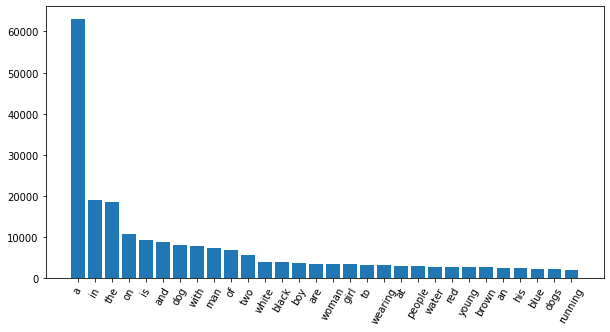

In [10]:
#Visualise the top 30 occuring words in the captions

top_30_vocab = val_count.most_common(30)
top_30_vocab

#write your code here
plt.figure(figsize=(10,5))
plt.xticks(rotation=60)
plt.bar(*zip(*top_30_vocab))


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer
top_k = 5000
tokenizer = Tokenizer(num_words = top_k, filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~', oov_token="<unk>")

#your code here
tokenizer.fit_on_texts(annotations)
#tokenizer.word_counts
#tokenizer.word_docs
#tokenizer.document_count
#tokenizer.texts_to_sequences(annotations)

In [12]:
# Create word-to-index and index-to-word mappings.

#your code here
word_index = tokenizer.word_index
index_word = tokenizer.index_word

#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'

print('Found %s unique tokens.' % len(word_index))

Found 8496 unique tokens.


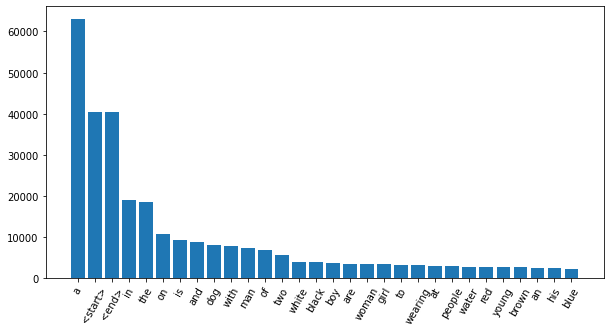

In [15]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
word_counter = Counter(tokenizer.word_counts)

top_30_words = word_counter.most_common(30)
top_30_words

#write your code here
plt.figure(figsize=(10,5))
plt.xticks(rotation=60)
plt.bar(*zip(*top_30_words))
plt.show()

In [16]:
sequences = tokenizer.texts_to_sequences(annotations)
MAX_SEQUENCE_LENGTH = max([len(caption_seq) for caption_seq in sequences])

In [17]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=0.0) #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [18]:
#write your code here to create the dataset consisting of image paths

image_dataset = tf.data.Dataset.from_tensor_slices (list(set(all_img_path)))

In [19]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path 

In [20]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_dataset = image_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


In [21]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [23]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

#image_features_extract_model.summary()

feature_dict = {}

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        #print(path_of_feature)
        np.save(path_of_feature, bf.numpy())
        #feature_dict[path_of_feature] =  bf.numpy()

100%|██████████| 253/253 [00:37<00:00,  6.69it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [24]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_path,
                                                              cap_vector,
                                                              test_size=0.2,
                                                              random_state=42)
                                                              #your all_img_pathcode goes here)

In [25]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path,caption): # your input variable goes here):
    # write your code here to extract the features from the dictionary stored earlier
    
    #path_of_feature = image_path.numpy().decode("utf-8") 
    img_tensor = np.load(image_path.decode('utf-8')+'.npy')
    #img_tensor = np.load(path_of_feature +'.npy')
    
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [27]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE = 64
BUFFER_SIZE = 1000

def gen_dataset(image_path, caption): #your input variables):
    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption))
    
    # your code goes here to create the dataset & transform it
    
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    
    return dataset



In [28]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [29]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [30]:
embedding_dim = 256 
units = 512
vocab_size = top_k + 1 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim) 
        #self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.nn.relu(self.dense(features)) 
        
        return features

In [32]:
encoder=Encoder(embedding_dim)

### Attention model

In [33]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [34]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [36]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [37]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [38]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [39]:
checkpoint_path = "./" #"your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [41]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [45]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        
        predicted_id =  tf.argmax(predictions[0])
            
        #dec_input = tf.expand_dims(target[:, i], 1)
        #dec_input = tf.expand_dims(predicted_id, 1)
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
            

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [46]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [47]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  5%|▌         | 1/20 [01:47<34:09, 107.86s/it]

For epoch: 1, the train loss is 0.415, & test loss is 2.237
Time taken for 1 epoch 107.72447180747986 sec

Test loss has been reduced from 100.000 to 2.237


 10%|█         | 2/20 [03:12<30:14, 100.80s/it]

For epoch: 2, the train loss is 0.391, & test loss is 2.327
Time taken for 1 epoch 84.32096195220947 sec



 15%|█▌        | 3/20 [04:37<27:12, 96.02s/it] 

For epoch: 3, the train loss is 0.370, & test loss is 2.404
Time taken for 1 epoch 84.86193561553955 sec



 20%|██        | 4/20 [06:01<24:42, 92.67s/it]

For epoch: 4, the train loss is 0.353, & test loss is 2.478
Time taken for 1 epoch 84.8680362701416 sec



 25%|██▌       | 5/20 [07:26<22:33, 90.24s/it]

For epoch: 5, the train loss is 0.338, & test loss is 2.585
Time taken for 1 epoch 84.54978632926941 sec



 30%|███       | 6/20 [08:51<20:40, 88.64s/it]

For epoch: 6, the train loss is 0.324, & test loss is 2.642
Time taken for 1 epoch 84.89978694915771 sec



 35%|███▌      | 7/20 [10:14<18:51, 87.05s/it]

For epoch: 7, the train loss is 0.313, & test loss is 2.666
Time taken for 1 epoch 83.33332991600037 sec



 40%|████      | 8/20 [11:37<17:09, 85.82s/it]

For epoch: 8, the train loss is 0.302, & test loss is 2.835
Time taken for 1 epoch 82.94267988204956 sec



 45%|████▌     | 9/20 [13:01<15:35, 85.08s/it]

For epoch: 9, the train loss is 0.291, & test loss is 2.846
Time taken for 1 epoch 83.3566381931305 sec



 50%|█████     | 10/20 [14:24<14:05, 84.52s/it]

For epoch: 10, the train loss is 0.278, & test loss is 2.951
Time taken for 1 epoch 83.20540523529053 sec



 55%|█████▌    | 11/20 [15:45<12:30, 83.40s/it]

For epoch: 11, the train loss is 0.270, & test loss is 3.087
Time taken for 1 epoch 80.78780698776245 sec



 60%|██████    | 12/20 [17:08<11:06, 83.35s/it]

For epoch: 12, the train loss is 0.262, & test loss is 3.067
Time taken for 1 epoch 83.22170567512512 sec



 65%|██████▌   | 13/20 [18:31<09:43, 83.30s/it]

For epoch: 13, the train loss is 0.254, & test loss is 3.078
Time taken for 1 epoch 83.2017674446106 sec



 70%|███████   | 14/20 [19:54<08:19, 83.30s/it]

For epoch: 14, the train loss is 0.248, & test loss is 3.176
Time taken for 1 epoch 83.27300477027893 sec



 75%|███████▌  | 15/20 [21:17<06:56, 83.27s/it]

For epoch: 15, the train loss is 0.240, & test loss is 3.190
Time taken for 1 epoch 83.1924991607666 sec



 80%|████████  | 16/20 [22:41<05:33, 83.26s/it]

For epoch: 16, the train loss is 0.231, & test loss is 3.319
Time taken for 1 epoch 83.22858715057373 sec



 85%|████████▌ | 17/20 [24:04<04:10, 83.35s/it]

For epoch: 17, the train loss is 0.226, & test loss is 3.326
Time taken for 1 epoch 83.56778836250305 sec



 90%|█████████ | 18/20 [25:27<02:46, 83.25s/it]

For epoch: 18, the train loss is 0.221, & test loss is 3.431
Time taken for 1 epoch 83.0003228187561 sec



 95%|█████████▌| 19/20 [26:50<01:23, 83.24s/it]

For epoch: 19, the train loss is 0.216, & test loss is 3.493
Time taken for 1 epoch 83.21871829032898 sec



100%|██████████| 20/20 [28:14<00:00, 84.71s/it]

For epoch: 20, the train loss is 0.211, & test loss is 3.636
Time taken for 1 epoch 83.20446109771729 sec



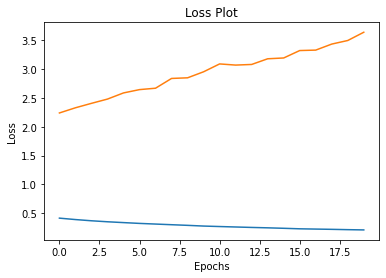

In [48]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [49]:
def evaluate(image):
    max_length=MAX_SEQUENCE_LENGTH
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [50]:
#def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
#    return final_caption



In [51]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [52]:
from nltk.translate.bleu_score import sentence_bleu

In [53]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [54]:
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

In [55]:
print(features_shape)
print(attention_features_shape)

2048
64


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 1.3483065280626045e-229
Real Caption: people enjoy time on boat
Prediction Caption: a group of people on a yellow and white boat


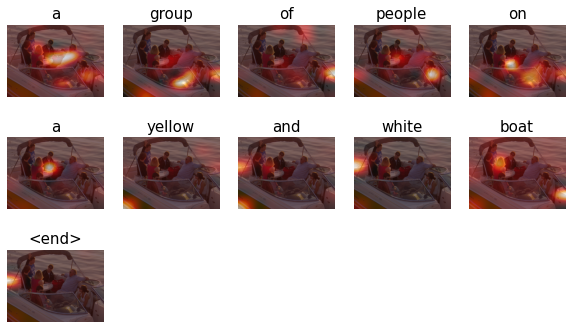

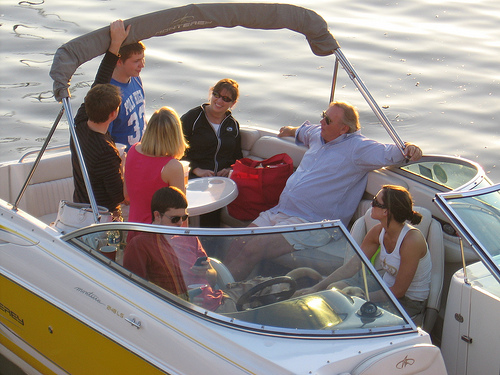

In [56]:
rid = np.random.randint(0, len(path_test))
test_image = list(path_test)[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25)) #set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [97]:
#captions=beam_evaluate(test_image)
#print(captions)